# My Prodcast prediction project

This project will attemp to predict podcast listening times using data

In [23]:
# Importing packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:
# Importing data
filepath_train_data = "data/train.csv"
filepath_test_data = "data/test.csv"

train_data = pd.read_csv(filepath_train_data)
test_data = pd.read_csv(filepath_test_data)

# Inspecting data

- Looking at usefulness of columns
- Understanding column types
    - Are numericals scaled
    - Are the numericals ordinal?
    - How to encode categorical variables

- Looking for missing targets
- Looking for missing predictors

- Visualizing target
- Visualizing predictors
    - Looking for outliers

- Checking for target leakage

In [3]:
# Inspecting columns
print(train_data.dtypes)


id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object


## Columns

**Most useful**
- Episode_Length_minutes - Numerical - Scaled
- Host_Popularity_percentage - Numerical - Scaled
- Guest_Popularity_percentage - Numerical - Scaled
- Genre - Categorical - Nominal
    - Encode with one-hot (most frequent as reference)
- Number_of_Ads - Numerical - Integers


**Possibly useful**
- Publication_Day - Categorical - Nominal
    - Split to Weekdays, fridays, saturdays and sundays?
- Publication_Time - Categorical - Nominal
    - Encode with one-hot (most frequent as reference)
- Episode_Sentiment - Categorical - Slightly Ordinal
    - Test ordinal encoding


**Difficult to use**
- Podcast_Name - Categorical - Nominal - High cardinality
    - Advanced: Encode average listening time for specific podcasts as a new column
    - Advanced: New column that counts number of podcasts
- Episode_Title - Categorical - Nominal - High cardinality
    - Very advanced: Extract keywords from name

**Target leakage**
No target leakage in any of the variables

In [4]:
# Missing values
print(train_data.count())
print("There are " + str(train_data.Listening_Time_minutes.notna().count()) + " values for the target")

id                             750000
Podcast_Name                   750000
Episode_Title                  750000
Episode_Length_minutes         662907
Genre                          750000
Host_Popularity_percentage     750000
Publication_Day                750000
Publication_Time               750000
Guest_Popularity_percentage    603970
Number_of_Ads                  749999
Episode_Sentiment              750000
Listening_Time_minutes         750000
dtype: int64
There are 750000 values for the target


In [5]:
# Missing values in test_data
print(test_data.count())

id                             250000
Podcast_Name                   250000
Episode_Title                  250000
Episode_Length_minutes         221264
Genre                          250000
Host_Popularity_percentage     250000
Publication_Day                250000
Publication_Time               250000
Guest_Popularity_percentage    201168
Number_of_Ads                  250000
Episode_Sentiment              250000
dtype: int64


There are no missing targets in the training data. Both the training and test data is missing quite a few values in Episode_Length_minutes and Host_Popularity_percentage. Train is also missing one value in Number_of_Ads.

### How to handle missing values
- Episode_Length_minutes
    - Easy: Impute mean
    - Advanced: Impute missing values with the average for episodes from the same Podcast_Name
- Host_Popularity_percentage
    - Easy: Impute mean
    - Advanced: Impute missing values with the average for episodes from the same Podcast_Name
- Number_of_Ads
    - Impute mean

In [6]:
# Filling missing value in number of ads
# Transforming Number of ads to integer for both training and test data

mode_ads = train_data["Number_of_Ads"].mode()[0]
train_data["Number_of_Ads"] = train_data["Number_of_Ads"].fillna(mode_ads).astype(int)
test_data["Number_of_Ads"] = test_data["Number_of_Ads"].astype(int)


# Feature Engineering

### Ideas for new columns
- Ads_Per_Minute = Number_of_Ads / Episode_Length_minutes
- Look for interaction terms
    - Length * Genre
    - Length * Sentiment



In [ ]:
# Creating Ads_per_Minute
print((train_data["Episode_Length_minutes"] == 0).sum()) # There is one where the episode length = 0
print((train_data["Episode_Length_minutes"] == 0).sum())

train_data = train_data[train_data["Episode_Length_minutes"] != 0] # removing value where episode length is 0

train_data["Ads_per_Minute"] = train_data["Number_of_Ads"] / train_data["Episode_Length_minutes"]
test_data["Ads_per_Minute"] = test_data["Number_of_Ads"] / test_data["Episode_Length_minutes"]


1
1


## Visualizing the data

- Listening_Time_minutes
    - Histogram or KDE
    - Boxplot 

**Most useful**
- Episode_Length_minutes / Host_Popularity_percentage / Guest_Popularity_percentage
    - Histogram or KDE for distribution
    - Scatterplot with lm
- Number_of_ads
    - Bar plots with count of ad numbers
    - Boxplot per number of ads
- Genre
    - Bar plots with count of Genres
    - Boxplot per number of Genre

**Possibly useful variables** 
- Publication_Day
    - Boxplots per day
- Publication_Time
    - Boxplots per time
- Episode_Sentiment
    - Boxplots per sentiment


**Interactions**
Dont know yet but definitelly interesting

### What to look for

Looking for possible transformations: Log or similar

<Axes: xlabel='Listening_Time_minutes', ylabel='Count'>

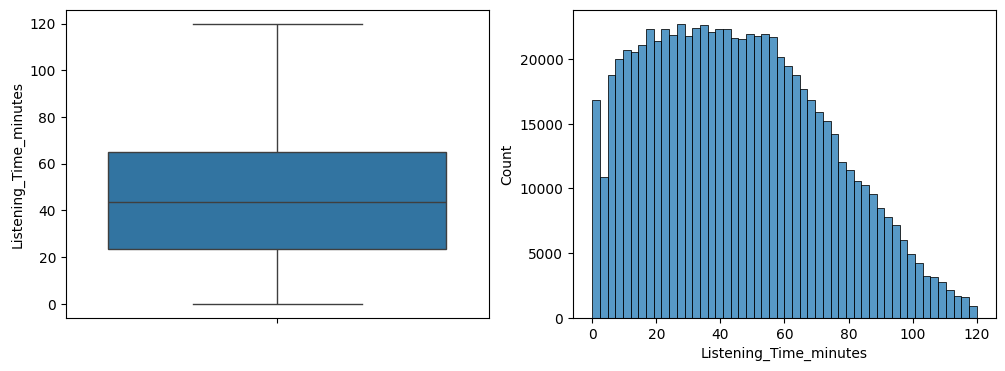

In [7]:
# Listening_Time_minutes (Target)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data = train_data["Listening_Time_minutes"], ax = axes[0])
sns.histplot(x = train_data["Listening_Time_minutes"], ax = axes[1], bins = 50)

# Seems like a exponential distribution
# Most observations in the 10-60 min range
# No outliers


<Axes: xlabel='Guest_Popularity_percentage', ylabel='Listening_Time_minutes'>

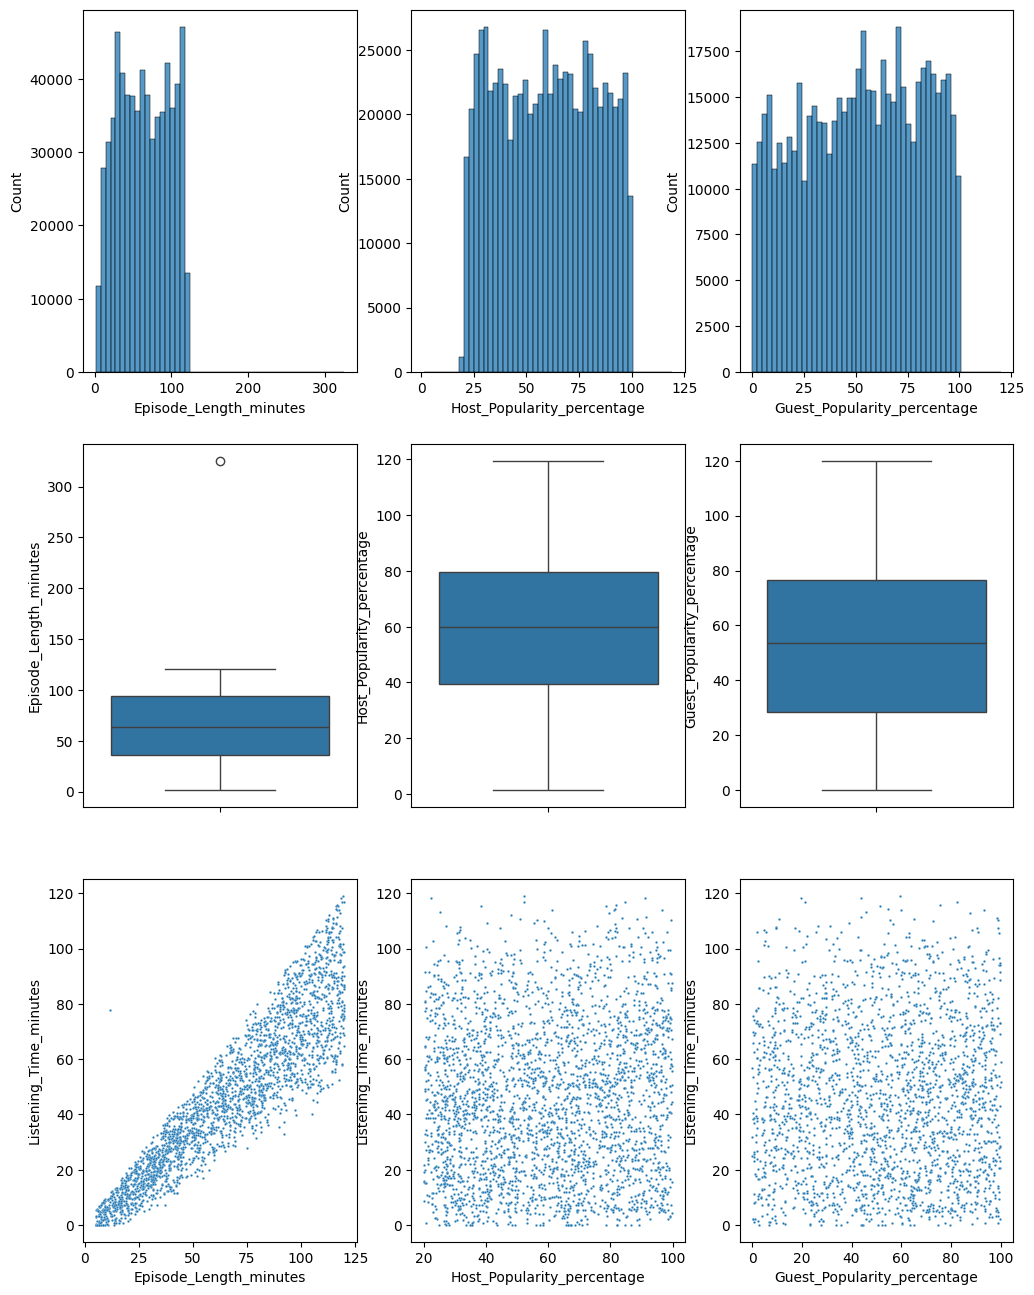

In [18]:
# Episode_Length_minutes / Host_Popularity_percentage / Guest_Popularity_percentage

fig, axes = plt.subplots(3, 3, figsize = (12, 16))

sns.histplot(x = train_data["Episode_Length_minutes"], ax = axes[0, 0], bins = 50)
sns.histplot(x = train_data["Host_Popularity_percentage"], ax = axes[0, 1], bins = 50)
sns.histplot(x = train_data["Guest_Popularity_percentage"], ax = axes[0, 2], bins = 50)

sns.boxplot(data = train_data["Episode_Length_minutes"], ax = axes[1, 0])
sns.boxplot(data = train_data["Host_Popularity_percentage"], ax = axes[1, 1])
sns.boxplot(data = train_data["Guest_Popularity_percentage"], ax = axes[1, 2])

scatter_sample = train_data.sample(3000)
sns.scatterplot(x = scatter_sample["Episode_Length_minutes"], y = scatter_sample["Listening_Time_minutes"], ax = axes[2, 0], s= 3)
sns.scatterplot(x = scatter_sample["Host_Popularity_percentage"], y = scatter_sample["Listening_Time_minutes"], ax = axes[2, 1], s = 3)
sns.scatterplot(x = scatter_sample["Guest_Popularity_percentage"], y = scatter_sample["Listening_Time_minutes"], ax = axes[2, 2], s= 3)


<Axes: xlabel='Number_of_Ads', ylabel='Listening_Time_minutes'>

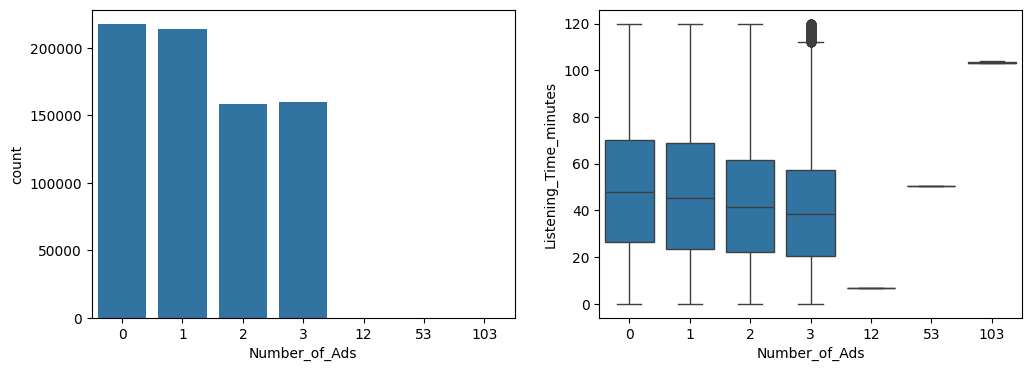

In [9]:
# Number of ads

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.countplot(data = train_data, x ="Number_of_Ads", ax = axes[0])
sns.boxplot(x = train_data["Number_of_Ads"], y = train_data["Listening_Time_minutes"], ax = axes[1]) 

#Only really values in 0-3 ad range
# Clear negative correlation with target

<Axes: xlabel='Genre', ylabel='Listening_Time_minutes'>

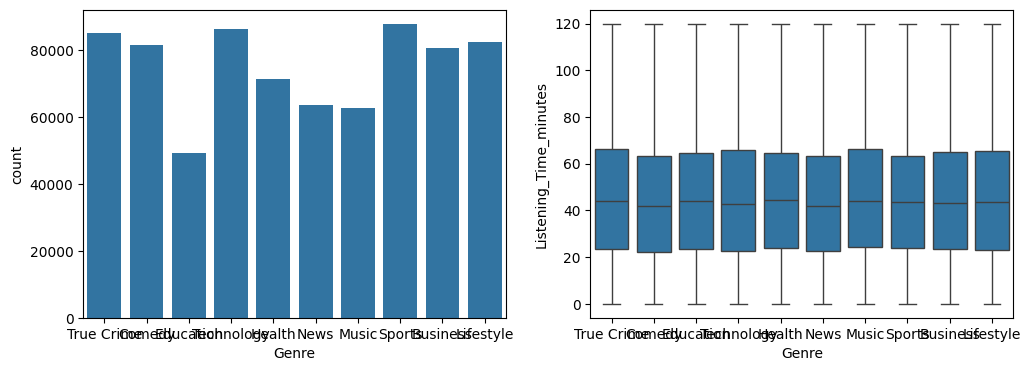

In [10]:
# Genre
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.countplot(data = train_data, x ="Genre", ax = axes[0])
sns.boxplot(x = train_data["Genre"], y = train_data["Listening_Time_minutes"], ax = axes[1]) 

# There is a decent amount of data on all genres, They do seem to affect listening times somewhat


<Axes: xlabel='Ads_per_Minute', ylabel='Listening_Time_minutes'>

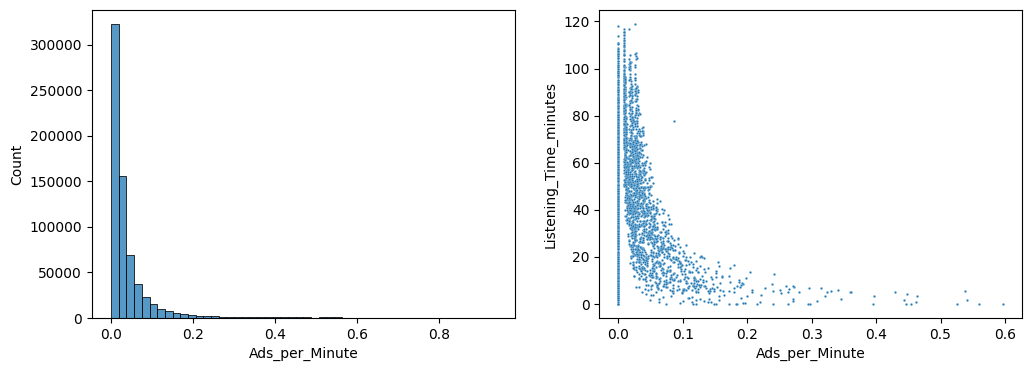

In [19]:
# Ads per minute
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(x = train_data["Ads_per_Minute"], ax = axes[0], bins = 50)
sns.scatterplot(x = scatter_sample["Ads_per_Minute"], y = scatter_sample["Listening_Time_minutes"], ax = axes[1], s= 3)


<Axes: xlabel='Episode_Sentiment', ylabel='Listening_Time_minutes'>

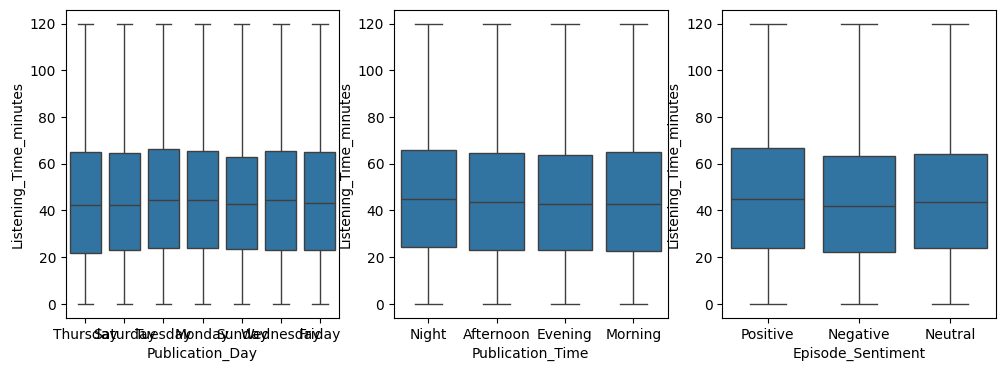

In [11]:
# Publication_Day / Publication_Time / Episode_Sentiment

fig, axes = plt.subplots(1, 3, figsize = (12, 4))

sns.boxplot(x = train_data["Publication_Day"], y = train_data["Listening_Time_minutes"], ax = axes[0]) 
sns.boxplot(x = train_data["Publication_Time"], y = train_data["Listening_Time_minutes"], ax = axes[1]) 
sns.boxplot(x = train_data["Episode_Sentiment"], y = train_data["Listening_Time_minutes"], ax = axes[2])

# No clear correlation with target

### Observations in visuals
- Listening_Time_minutes (Target):
    - Right skewed distribution. Starts flat, then exponential to the right
    - Most values between 10-60 min

- Episode_Length_minutes
    - Linear relationship with target
    - 1 massive outlier found. Study more!
    - Look for interaction terms!

- Host_Popularity_percentage / Guest_Popularity_percentage
    - No apparent relationship with target, seems random

- Number_of_Ads
    - Clear negative relationship with target
    - Only data for 0-3 ads
    - Look for ratio or interaction term?
- Genre
    - Some correlation between genre and target
    - Enough data to motivate one-hot encoding
- Publication_Day / Publication_Time / Episode_Sentiment
    - No clear relationship with target
    - Study interaction terms


## Correlation and other data

In this chapter I will look into the correlation between the target and predictors and between the predictors themselves

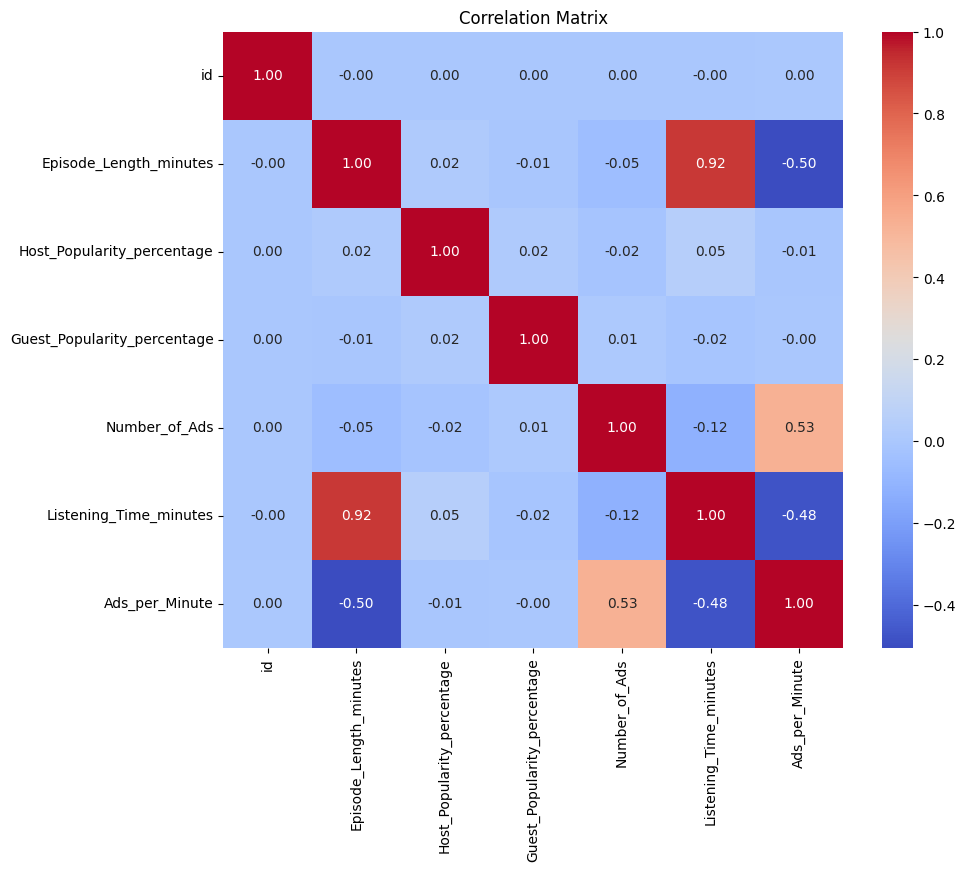

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Ads_per_Minute
id,1.000000,-0.000561,0.000274,0.000637,0.000768,-0.000878,0.001608
Episode_Length_minutes,-0.000561,1.000000,0.023595,-0.009704,-0.054982,0.916749,-0.504201
Host_Popularity_percentage,0.000274,0.023595,1.000000,0.022431,-0.017899,0.050869,-0.008361
Guest_Popularity_percentage,0.000637,-0.009704,0.022431,1.000000,0.007936,-0.016014,-0.000185
Number_of_Ads,0.000768,-0.054982,-0.017899,0.007936,1.000000,-0.118388,0.526175
Listening_Time_minutes,-0.000878,0.916749,0.050869,-0.016014,-0.118388,1.000000,-0.480451
Ads_per_Minute,0.001608,-0.504201,-0.008361,-0.000185,0.526175,-0.480451,1.000000


In [17]:


plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

train_data.corr(numeric_only=True)

In [13]:
# Comparing listening time when there is guest versus when there is not

# Create masks
has_guest = train_data["Guest_Popularity_percentage"].notna()
no_guest = train_data["Guest_Popularity_percentage"].isna()

# Compare mean listening time
mean_with_guest = train_data.loc[has_guest, "Listening_Time_minutes"].mean()
mean_without_guest = train_data.loc[no_guest, "Listening_Time_minutes"].mean()

print(f"Mean listening time WITH guest: {mean_with_guest:.2f} minutes")
print(f"Mean listening time WITHOUT guest: {mean_without_guest:.2f} minutes")

Mean listening time WITH guest: 45.48 minutes
Mean listening time WITHOUT guest: 45.28 minutes


From the correlation data. I can conclude that Episode Length is by far the most important variable. Then number of ads seems quite important. 

It is also possible that Host popularity is also significant although to a lower degree.


There is no issue with colinearity as none of the predictors are correlated at any significant level

The episodes without guests have slightly lower listening times, but the difference is extremely small

# Building the model

Start by splitting off 20% of data for validation
Also always use cross validation to investigate hyperparameters

Use RMSE for evaluation

Build function to evaluate performance

Building pipeline:
Prepare columns 
Imputing missing values

Start simple, use only Episode_Length

In [15]:
# Splitting off validation data

X = train_data.drop(columns = ["Listening_Time_minutes"])
y = train_data["Listening_Time_minutes"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Creating set without outlier
train_data_no = train_data[(train_data["Episode_Length_minutes"].isna()) | 
                           (train_data["Episode_Length_minutes"] < 300)]

X_no = train_data_no.drop(columns = ["Listening_Time_minutes"])
y_no = train_data_no["Listening_Time_minutes"]

X_train_no, X_val_no, y_train_no, y_val_no = train_test_split(
    X_no, y_no, test_size=0.2, random_state=42
)

In [16]:
# Building evaluation function

def evaluate_model_rmse(model, X, y, cv = 3):
    """
    Evaluate a model using cross validation and return mean RMSE

    Parameters:
    - model: a scikit_learn model or pipeline
    - X: feature matrix
    - y: target vector
    - cv: number of cross-validation folds (default is 5)

    Returns:
    - Mean RMSE score (float)
    """

    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    scores = cross_val_score(
        model,
        X,
        y,
        scoring = "neg_root_mean_squared_error",
        cv = kfold,
        n_jobs = 1,
    )

    rmse_scores = -scores
    mean_rmse = np.mean(rmse_scores)

    print(f"Mean RMSE (CV={cv}): {mean_rmse:.4f}")
    return mean_rmse


def evaluate_model_rmse_validation(model, X_train, y_train, X_val, y_val):
    """
    Train the model on training data and evaluate RMSE on validation data.

    Parameters:
    - model: a scikit-learn model or pipeline
    - X_train: training feature matrix
    - y_train: training target vector
    - X_val: validation feature matrix
    - y_val: validation target vector

    Returns:
    - RMSE on the validation set (float)
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, predictions)

    print(f"Validation RMSE: {rmse:.4f}")
    return rmse


## Results

| Name  | Model         | Parameters       | Predictors                    | Imputer       | CV | Outlier | Result            |
|-------|---------------|------------------|-------------------------------|---------------|----|---------|-------------------|
| m1    | RandomForrest | n_est = 100      | Episode_length                | Mean imputer  | 5  | Nothing |13.463830436498167
| m1    | RandomForrest | n_est= 30        | Episode_length                | Mean imputer  | 3  | Nothing |13.4881
| m2    | RandomForrest | n_est = 30       | Episode_length, Ads           | Mean imputer  | 3  | Nothing |13.5017
| m2    | RandomForrest | n_est = 30       | Episode_length, Ads           | Mean imputer  | 3  | TOO MUCH|10.788963513369243
| m2    | RandomForrest | n_est = 30       | Episode_length, Ads           | Mean imputer  | 3  | Removed |13.5131
| m3    | RandomForrest | n_est = 30       | Episode_length, Ads, Host_pop | Mean imputer  | 3  | Nothing |14.1880
| m4    | RandomForrest | n_est = 30       | Episode_length, Ads, Host_pop, Genre | Mean imputer  | 3  | Nothing |13.9957
| m5    | RandomForrest | n_est = 30       | Episode_length, Ads, Host_pop, Genre, Ads_per_min | Mean imputer  | 3  | Nothing |14.0260
| XG5   | XGB     | n_est = 100, learn = 0.1 | Episode_length, Ads, Host_pop, Genre, Ads_per_min | Mean imputer  | 3  | Nothing |13.1621
| XG6   | XGB     | n_est = 100, learn = 0.1 | Episode_length, Genre | Mean imputer  | 3  | Nothing |13.5020
| XG7   | XGB     | n_est = 100, learn = 0.1 | Episode_length, Genre, Ads_per_Minute | Mean imputer  | 3  | Nothing |13.3034
| XG8   | XGB     | n_est = 100, learn = 0.1 | Episode_length, Genre, Ads_per_Minute, Ads | Mean imputer  | 3  | Nothing |13.2672



In [ ]:
# Building basic model

m1_features = ["Episode_Length_minutes"]

X_m1 = X_train[m1_features]

m1_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", RandomForestRegressor(n_estimators=30, random_state=42))
])

evaluate_model_rmse(m1_pipeline, X_m1, y_train)


Mean RMSE (CV=3): 13.4881


np.float64(13.488137026491566)

In [ ]:
# Adding Number of ads as predictor

m2_features = ["Episode_Length_minutes", "Number_of_Ads"]

X_m2 = X_train[m2_features]

m2_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", RandomForestRegressor(n_estimators=30, random_state=42))
])

evaluate_model_rmse(m2_pipeline, X_m2, y_train)


Mean RMSE (CV=3): 13.5017


np.float64(13.5017174819374)

In [ ]:
# Adding host popularity as predictor

m3_features = ["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage"]

X_m3 = X_train[m3_features]

m3_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", RandomForestRegressor(n_estimators=30, random_state=42))
])

evaluate_model_rmse(m3_pipeline, X_m3, y_train)


Mean RMSE (CV=3): 14.1880


np.float64(14.188008950893474)

In [ ]:
# Adding Genres as predictor

m4_features = ["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage", "Genre"]

X_m4 = X_train[m4_features]

m4_num_features = ["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage"]
m4_cat_features = ["Genre"]

m4_preprocessor = ColumnTransformer(transformers = [
    ("num", SimpleImputer(strategy="mean"), m4_num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), m4_cat_features)
    ])

m4_pipeline = Pipeline([
    ("preprocessor", m4_preprocessor),
    ("model", RandomForestRegressor(n_estimators=30, random_state=42))
])

evaluate_model_rmse(m4_pipeline, X_m4, y_train)


Mean RMSE (CV=3): 13.9957


np.float64(13.995705301617377)

In [ ]:
# Adding Ads_per_minute as predictor

m5_features = ["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage", "Genre", "Ads_per_Minute"]

X_m5 = X_train[m5_features]

m5_num_features = ["Episode_Length_minutes", "Number_of_Ads", "Host_Popularity_percentage", "Ads_per_Minute"]
m5_cat_features = ["Genre"]

m5_preprocessor = ColumnTransformer(transformers = [
    ("num", SimpleImputer(strategy="mean"), m5_num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), m5_cat_features)
    ])

m5_pipeline = Pipeline([
    ("preprocessor", m5_preprocessor),
    ("model", RandomForestRegressor(n_estimators=30, random_state=42))
])

evaluate_model_rmse(m5_pipeline, X_m5, y_train)


Mean RMSE (CV=3): 14.0260


np.float64(14.026046071294664)

# Testing new models
Below I am going to be testing using XGBooster instead of RandomForrest

In [33]:
# Testing m5 using XGBoost

m5_xgb_pipeline = Pipeline([
    ("preprocessor", m5_preprocessor),
    ("model", XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Evaluate using your CV function
evaluate_model_rmse(m5_xgb_pipeline, X_m5, y_train)

Mean RMSE (CV=3): 13.1621


np.float64(13.162149747364374)

In [27]:
# Testing m6 using XGBoost

m6_features = ["Episode_Length_minutes", "Genre"]

X_m6 = X_train[m6_features]

m6_num_features = ["Episode_Length_minutes"]
m6_cat_features = ["Genre"]

m6_preprocessor = ColumnTransformer(transformers = [
    ("num", SimpleImputer(strategy="mean"), m6_num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), m6_cat_features)
    ])


m6_xgb_pipeline = Pipeline([
    ("preprocessor", m6_preprocessor),
    ("model", XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Evaluate using your CV function
evaluate_model_rmse(m6_xgb_pipeline, X_m6, y_train)

Mean RMSE (CV=3): 13.5020


np.float64(13.502001720725618)

In [32]:
# Testing m7 using XGBoost

m7_features = ["Episode_Length_minutes", "Genre", "Ads_per_Minute", "Number_of_Ads"]

X_m7 = X_train[m7_features]

m7_num_features = ["Episode_Length_minutes", "Ads_per_Minute", "Number_of_Ads"]
m7_cat_features = ["Genre"]

m7_preprocessor = ColumnTransformer(transformers = [
    ("num", SimpleImputer(strategy="mean"), m7_num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), m7_cat_features)
    ])


m7_xgb_pipeline = Pipeline([
    ("preprocessor", m7_preprocessor),
    ("model", XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Evaluate using your CV function
evaluate_model_rmse(m7_xgb_pipeline, X_m7, y_train)

Mean RMSE (CV=3): 13.2672


np.float64(13.267194114095872)

## Outlier analysis

There is a large outlier in the predictor space or episode_length, this is removed in the code above.
The models below do not include this outlier

In [ ]:
# Evaluating model without outlier using m2

X_m2_no = X_train_no[m2_features]
X_val_m2 = X_val[m2_features]

evaluate_model_rmse(m2_pipeline, X_m2_no, y_train_no)
evaluate_model_rmse_validation(m2_pipeline, X_m2_no, y_train_no, X_val_m2, y_val)


Mean RMSE (CV=3): 13.5131
Validation RMSE: 12.9487


12.948720228517294

In [35]:
# Evaluating m5 without outliers, using XGBoost

X_m5_no = X_train_no[m5_features]

evaluate_model_rmse(m5_xgb_pipeline, X_m5_no, y_train_no)


Mean RMSE (CV=3): 13.1615


np.float64(13.161468591561691)

Unclear if removing the outlier made performance better or worse... CV scores got worse. But validation RMSE was quite high

# Building final model and predicting on Test data

In [37]:
# Define test feature matrix
X_test_m5 = test_data[m5_features]

# Refit model on full cleaned training data
X_train_final = train_data_no[m5_features]
y_train_final = train_data_no["Listening_Time_minutes"]

m5_xgb_pipeline.fit(X_train_final, y_train_final)

# Predict
test_predictions = m5_xgb_pipeline.predict(X_test_m5)

# Create submission
submission = pd.DataFrame({
    "id": test_data["id"],
    "listening_time_minutes": test_predictions
})

submission.to_csv("submission.csv", index=False)
print("✅ Submission file created!")

✅ Submission file created!


# Next things to do

Up the parameters in RandomForrest and CV

Find a better way of imputing Episode length than just using average

Test guest popularity with NaN as 0?

See if there are interaction terms between sentiment, publication day/time and length or similar
